In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
import glob
import cv2
import imutils
import seaborn as sns
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from keras.models import Model, Sequential
import keras


In [2]:
!unzip '/content/brain tumor dataset.zip'

Archive:  /content/brain tumor dataset.zip
  inflating: no/1 no.jpeg            
  inflating: no/10 no.jpg            
  inflating: no/11 no.jpg            
  inflating: no/12 no.jpg            
  inflating: no/13 no.jpg            
  inflating: no/14 no.jpg            
  inflating: no/15 no.jpg            
  inflating: no/17 no.jpg            
  inflating: no/18 no.jpg            
  inflating: no/19 no.jpg            
  inflating: no/2 no.jpeg            
  inflating: no/20 no.jpg            
  inflating: no/21 no.jpg            
  inflating: no/22 no.jpg            
  inflating: no/23 no.jpg            
  inflating: no/24 no.jpg            
  inflating: no/25 no.jpg            
  inflating: no/26 no.jpg            
  inflating: no/27 no.jpg            
  inflating: no/28 no.jpg            
  inflating: no/29 no.jpg            
  inflating: no/3 no.jpg             
  inflating: no/30 no.jpg            
  inflating: no/31 no.jpg            
  inflating: no/32 no.jpg            
  infla

In [3]:
!mkdir brain_tumor_dataset

mkdir: cannot create directory ‘brain_tumor_dataset’: File exists


In [4]:
root =  '/content/brain_tumor_dataset'
dict_img = {}
for dir in os.listdir(root):
  dict_img[dir] = len(os.listdir(os.path.join(root, dir)))
dict_img

{'no': 98, 'yes': 155}

Text(0.5, 1.0, 'no')

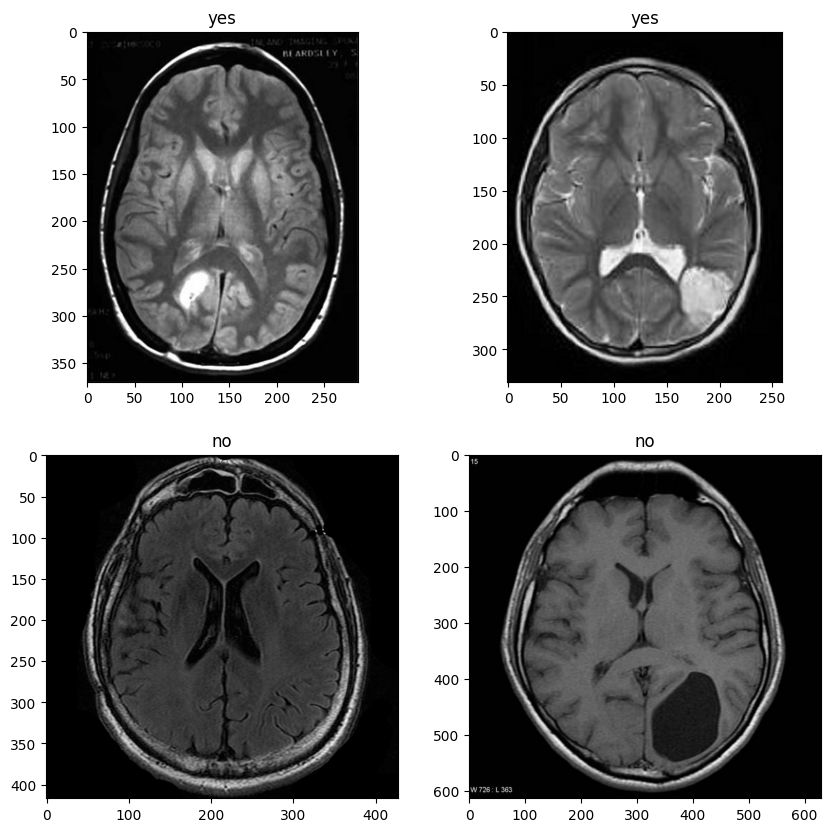

In [5]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(load_img(os.path.join('yes', os.listdir('yes')[0])))
plt.title('yes')
plt.subplot(2, 2, 2)
plt.imshow(load_img(os.path.join('yes', os.listdir('yes')[1])))
plt.title('yes')

plt.subplot(2, 2, 3)
plt.imshow(load_img(os.path.join('no', os.listdir('no')[0])))
plt.title('no')
plt.subplot(2, 2, 4)
plt.imshow(load_img(os.path.join('no', os.listdir('no')[1])))
plt.title('no')

In [6]:
def augment_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.1,
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='nearest',
                                  rescale= 1/255
                                 )

    for filename in os.listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
                i += 1
                if i > n_generated_samples:
                    break

In [7]:
name = 'aug_data'
if not os.path.exists("./"+name):
  os.mkdir("./"+name)
  for dir in os.listdir(root):
    os.makedirs("./"+name+"/"+dir)
else:
  print(f"{name} Already exists")

aug_data Already exists


In [8]:
#Augment data for the examples with the label 'yes' in the training set
augment_data(file_dir='/content/brain_tumor_dataset/yes',n_generated_samples=8, save_to_dir='/content/aug_data/yes')
#Augment data for the examples with the label 'no' in the training set
augment_data(file_dir='/content/brain_tumor_dataset/no', n_generated_samples=12, save_to_dir='/content/aug_data/no')

In [9]:
root =  '/content/aug_data'
dict_img = {}
for dir in os.listdir(root):
  dict_img[dir] = len(os.listdir(os.path.join(root, dir)))
dict_img

{'.ipynb_checkpoints': 0, 'no': 1273, 'yes': 1396}

In [10]:
def create_folders(name, perc):
  if not os.path.exists("./"+name):
    os.mkdir("./"+name)
    for dir in os.listdir(root):
      os.makedirs("./"+name+"/"+dir)
      for img in np.random.choice(a=os.listdir(os.path.join(root, dir)), size=(math.floor(perc*dict_img[dir])), replace=False):
        Src = os.path.join(root, dir, img)
        Dest = os.path.join("./"+name, dir)
        shutil.copy(Src, Dest)
        os.remove(Src)
  else:
    print(f"{name} Already exists")

In [11]:
create_folders('train', 0.7)

train Already exists


In [12]:
create_folders('test', 0.15)

test Already exists


In [13]:
create_folders('val', 0.15)

val Already exists


In [14]:
def count_img(folder):
  dict_img = {}
  for dir in os.listdir(folder):
    dict_img[dir] = len(os.listdir(os.path.join(folder, dir)))
  return dict_img

count_img('train')

{'.ipynb_checkpoints': 0, 'no': 891, 'yes': 976}

In [15]:
count_img('test')


{'.ipynb_checkpoints': 0, 'no': 190, 'yes': 209}

In [16]:
count_img('val')

{'.ipynb_checkpoints': 0, 'no': 190, 'yes': 209}

In [17]:
def crop_brain_contour(image, plot=False):

    #Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    #Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    #Extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    #Crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()

    return new_image

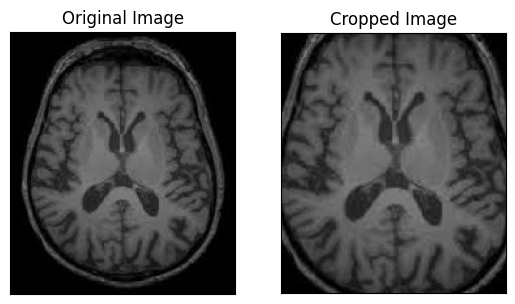

In [18]:
ex_img = cv2.imread('/content/brain_tumor_dataset/no/10 no.jpg')
img = crop_brain_contour(ex_img, plot=True)

In [19]:
def load_data(dir_list, image_size):

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size

    for directory in dir_list:
        for filename in os.listdir(directory):
            image = cv2.imread(directory+'/'+filename)
            image = crop_brain_contour(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])

    X = np.array(X)
    y = np.array(y)

    # Shuffle the data
    X, y = shuffle(X, y)

    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')

    return X, y

In [20]:
#Load trainig data
IMG_WIDTH, IMG_HEIGHT = (240, 240)
X_train, y_train = load_data(['/content/train/yes', '/content/train/no'], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 1867
X shape is: (1867, 240, 240, 3)
y shape is: (1867, 1)


In [21]:
def plot_sample_images(X, y, n=40):
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(10, 8))

        i = 1 # current plot
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])

            # remove ticks
            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)

            i += 1

        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

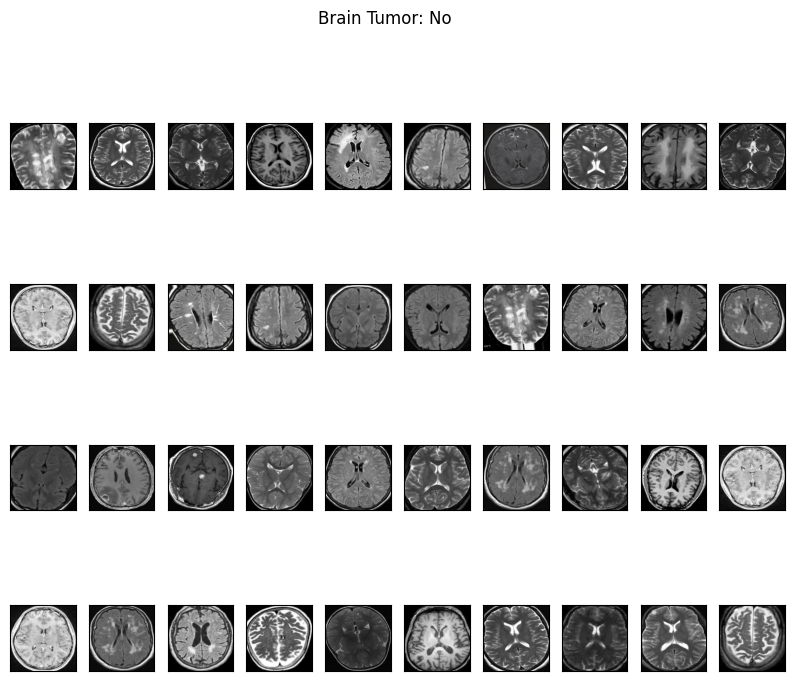

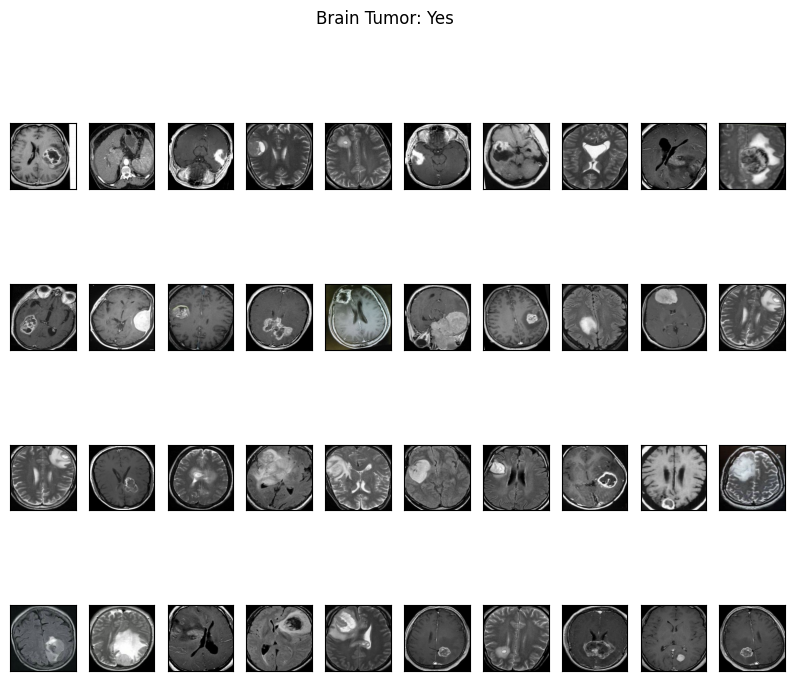

In [22]:
plot_sample_images(X_train, y_train)

In [23]:
IMG_WIDTH, IMG_HEIGHT = (240, 240)
X_test, y_test = load_data(['/content/test/yes', '/content/test/no'], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 399
X shape is: (399, 240, 240, 3)
y shape is: (399, 1)


In [24]:
IMG_WIDTH, IMG_HEIGHT = (240, 240)
X_val, y_val = load_data(['/content/val/yes', '/content/val/no'], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 399
X shape is: (399, 240, 240, 3)
y shape is: (399, 1)


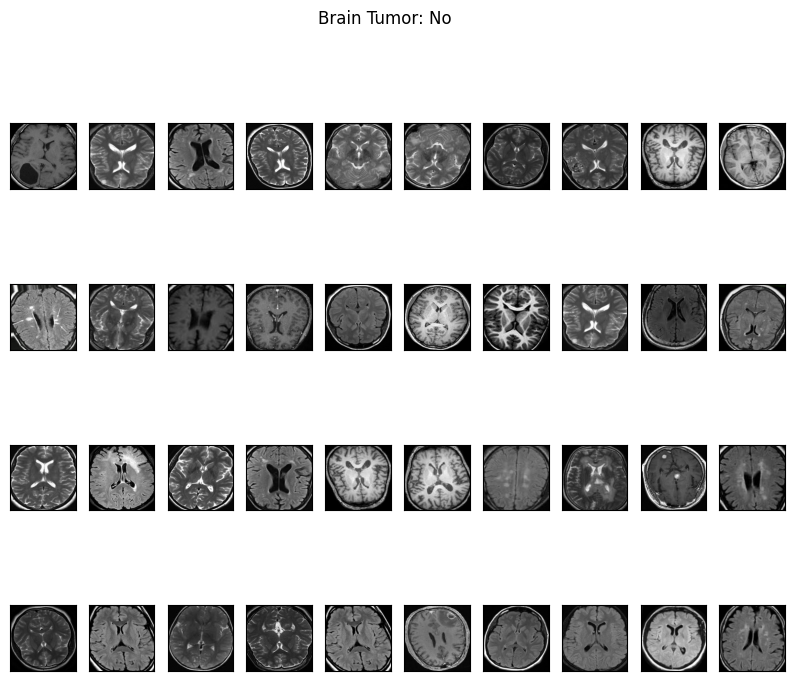

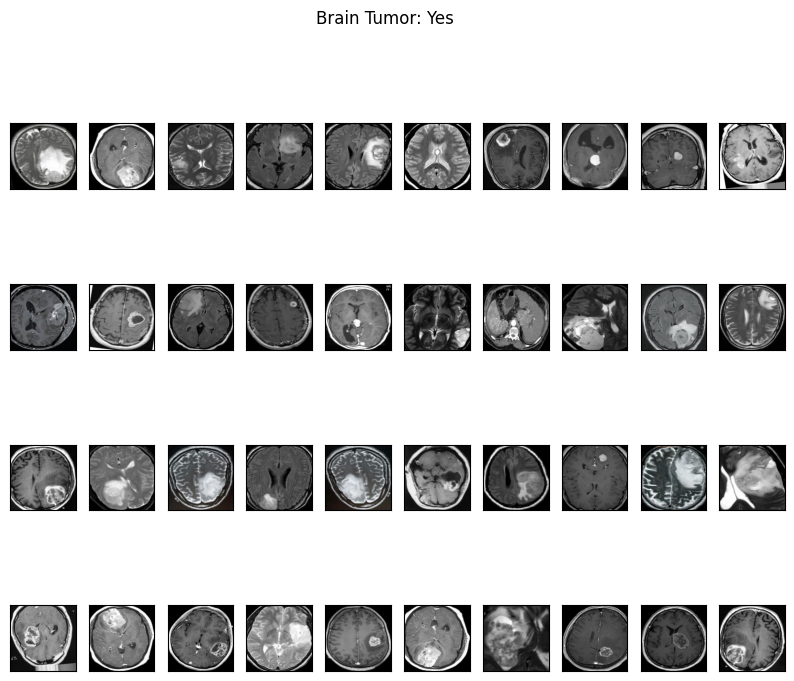

In [25]:
plot_sample_images(X_val, y_val)

In [26]:
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', input_shape = (240, 240, 3)))

model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Dropout(rate = 0.25))

model.add(Flatten())
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dropout(rate = 0.25))
model.add(Dense(units = 1, activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 238, 238, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 236, 236, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2  (None, 118, 118, 32)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 116, 116, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 58, 58, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 56, 56, 128)       7

In [27]:
model.compile(optimizer = 'adam', loss = keras.losses.binary_crossentropy, metrics = ['accuracy'])

In [28]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

es = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.01, patience = 5, verbose = 1, mode = 'auto')
mc = ModelCheckpoint(monitor ='val_accuracy', filepath = './bestmodel.h5', verbose = 1, save_best_only = True, mode = 'auto')

cd = [es, mc]

In [29]:
hist = model.fit(x = X_train, y = y_train, batch_size = 32, epochs = 30, validation_data = (X_val, y_val), callbacks = cd, verbose = 1)


Epoch 1/30
59/59 [==============================] - ETA: 0s - loss: 0.6990 - accuracy: 0.5635
Epoch 1: val_accuracy improved from -inf to 0.67419, saving model to ./bestmodel.h5
59/59 [==============================] - 351s 6s/step - loss: 0.6990 - accuracy: 0.5635 - val_loss: 0.6167 - val_accuracy: 0.6742
Epoch 2/30
59/59 [==============================] - ETA: 0s - loss: 0.4988 - accuracy: 0.7702
Epoch 2: val_accuracy improved from 0.67419 to 0.80200, saving model to ./bestmodel.h5
59/59 [==============================] - 344s 6s/step - loss: 0.4988 - accuracy: 0.7702 - val_loss: 0.4425 - val_accuracy: 0.8020
Epoch 3/30
59/59 [==============================] - ETA: 0s - loss: 0.3980 - accuracy: 0.8286
Epoch 3: val_accuracy improved from 0.80200 to 0.83709, saving model to ./bestmodel.h5
59/59 [==============================] - 346s 6s/step - loss: 0.3980 - accuracy: 0.8286 - val_loss: 0.3735 - val_accuracy: 0.8371
Epoch 4/30
59/59 [==============================] - ETA: 0s - loss: 0.

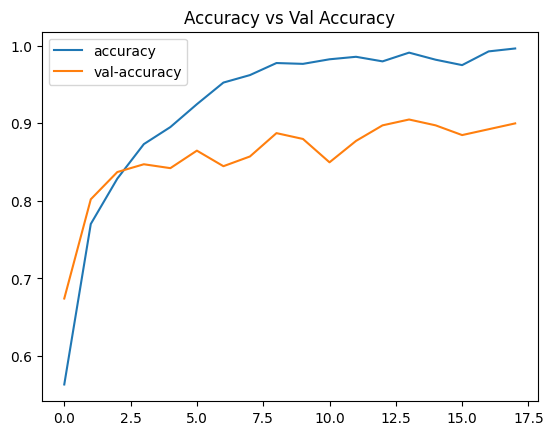

In [30]:
h = hist.history
plt.plot(h['accuracy'], label = 'accuracy')
plt.plot(h['val_accuracy'], label = 'val-accuracy')
plt.title('Accuracy vs Val Accuracy')
plt.legend()
plt.show()

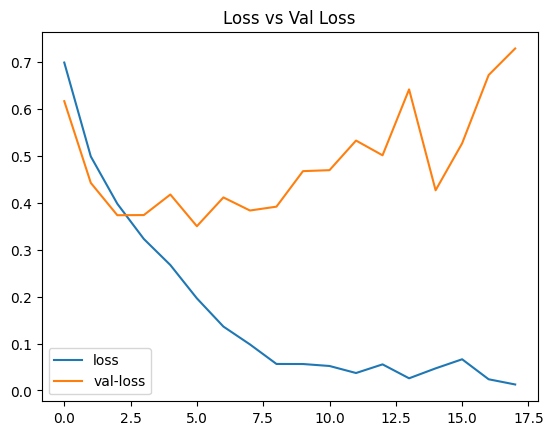

In [32]:
h = hist.history
plt.plot(h['loss'], label = 'loss')
plt.plot(h['val_loss'], label = 'val-loss')
plt.title('Loss vs Val Loss')
plt.legend()
plt.show()

In [52]:
from keras.preprocessing.image import load_img, img_to_array
#Choose a MRI image with tumor
path = "/content/aug_data/yes/aug_Y100_0_3328.jpg"
img_yes = load_img(path, target_size=(240,240))
img_array_yes = img_to_array(img_yes)/255
img_array_yes = np.expand_dims(img_array_yes, axis=0)
prediction1 = model.predict(img_array_yes)
class1 = np.round(prediction1).astype(int)
if class1 == 0:
  print("The MRI image doesn't have a Tumor")
else:
  print("The MRI image has a tumor")
prediction1

1/1 [==============================] - 0s 128ms/step
The MRI image has a tumor


array([[1.]], dtype=float32)

In [55]:
from keras.preprocessing.image import load_img, img_to_array
#Choose a MRI image without tumor
path = "/content/aug_data/no/aug_22 no_0_6265.jpg"
img_no = load_img(path, target_size=(240,240))
img_array_no = img_to_array(img_no)/255
img_array_no = np.expand_dims(img_array_no, axis=0)
prediction2 = model.predict(img_array_no)[0][0]
class2 = np.round(prediction2).astype(int)
if class2 == 0:
  print("The MRI image doesn't have a Tumor")
else:
  print("The MRI image has a tumor")

1/1 [==============================] - 0s 65ms/step
The MRI image doesn't have a Tumor


In [60]:
#Import MobileNet Model
from keras.applications.mobilenet import MobileNet
base_model = MobileNet(input_shape=(240,240,3), include_top=False)

#Make the layers of the model untrainable
for layer in base_model.layers:
  layer.trainable = False


#Add a flatten and dense layers to the base model
X = Flatten()(base_model.output)
X = Dense(units=1, activation='sigmoid')(X)
transfer_model = Model(base_model.input, X)


transfer_model.summary()

17225924/17225924 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 120, 120, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 120, 120, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 120, 120, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 120, 120, 32)      288       
 )                                                               
                                                              

In [61]:
#Compile the new model
transfer_model.compile(optimizer='rmsprop', loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

In [62]:
est = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.01, patience = 5, verbose = 1, mode = 'auto')
mct = ModelCheckpoint(monitor ='val_accuracy', filepath = './besttransfermodel.h5', verbose = 1, save_best_only = True, mode = 'auto')

cdt = [est, mct]

In [63]:
transfer_hist = transfer_model.fit(x = X_train, y = y_train, batch_size = 32, epochs = 30, validation_data = (X_val, y_val), callbacks = cdt, verbose = 1)


Epoch 1/30
59/59 [==============================] - ETA: 0s - loss: 2.5143 - accuracy: 0.8222
Epoch 1: val_accuracy improved from -inf to 0.94486, saving model to ./besttransfermodel.h5
59/59 [==============================] - 140s 2s/step - loss: 2.5143 - accuracy: 0.8222 - val_loss: 0.2761 - val_accuracy: 0.9449
Epoch 2/30
59/59 [==============================] - ETA: 0s - loss: 0.4792 - accuracy: 0.9529
Epoch 2: val_accuracy did not improve from 0.94486
59/59 [==============================] - 140s 2s/step - loss: 0.4792 - accuracy: 0.9529 - val_loss: 1.0693 - val_accuracy: 0.8672
Epoch 3/30
59/59 [==============================] - ETA: 0s - loss: 0.2686 - accuracy: 0.9770
Epoch 3: val_accuracy improved from 0.94486 to 0.96491, saving model to ./besttransfermodel.h5
59/59 [==============================] - 109s 2s/step - loss: 0.2686 - accuracy: 0.9770 - val_loss: 0.2059 - val_accuracy: 0.9649
Epoch 4/30
59/59 [==============================] - ETA: 0s - loss: 0.3053 - accuracy: 0.9

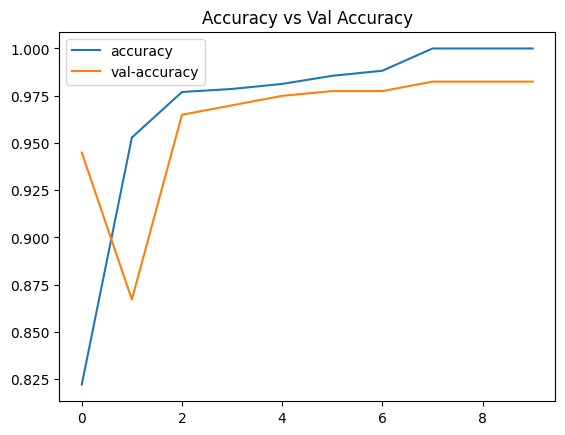

In [64]:
h = transfer_hist.history
plt.plot(h['accuracy'], label = 'accuracy')
plt.plot(h['val_accuracy'], label = 'val-accuracy')
plt.title('Accuracy vs Val Accuracy')
plt.legend()
plt.show()

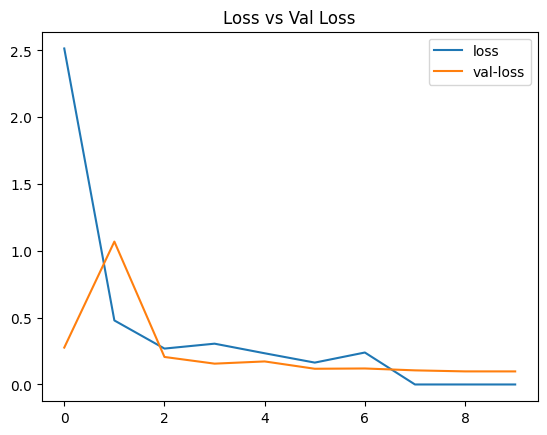

In [65]:
h = transfer_hist.history
plt.plot(h['loss'], label = 'loss')
plt.plot(h['val_loss'], label = 'val-loss')
plt.title('Loss vs Val Loss')
plt.legend()
plt.show()

In [68]:
from keras.models import load_model
model = load_model('/content/besttransfermodel.h5')
acc = model.evaluate(X_test, y_test)[1]
print(f'The accuracy of our model is {acc}')

13/13 [==============================] - 21s 1s/step - loss: 0.0591 - accuracy: 0.9925
The accuracy of our model is 0.9924812316894531


In [75]:
from keras.preprocessing.image import load_img, img_to_array
#Choose a MRI image without tumor
img_path = "/content/test/yes/aug_Y13_0_9896.jpg"
img_no = load_img(path, target_size=(240,240))
img_array_no = img_to_array(img_no)/255
img_array_no = np.expand_dims(img_array_no, axis=0)
prediction2 = model.predict(img_array_no)[0][0]
class2 = np.round(prediction2).astype(int)
if class2 == 0:
  print("The MRI image doesn't have a Tumor")
else:
  print("The MRI image has a tumor")

1/1 [==============================] - 0s 93ms/step
The MRI image has a tumor
